In [38]:
#importing libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
%matplotlib inline

In [14]:
#importing files in pandas dataframe
train = pd.read_csv('train.csv',header=0)
test = pd.read_csv('test.csv',header = 0)
labels = train['label']
train.drop('label',axis=1, inplace =True)
#test shape =(28000,784), train shape =(42000,784), labels shape = (42000,1)

In [15]:
#Converting dataframes into numpy arrays
train = train.as_matrix()
test = test.as_matrix()
labels = labels.as_matrix()

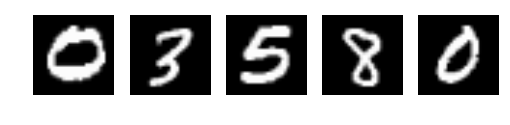

Labels: [0, 3, 5, 8, 0]


In [16]:
#Visualization of few random hand written digits
fig = plt.figure()
randLabels = []
for i in range(1,6):
    k = random.randrange(0,42000,10)
    ax = fig.add_subplot(1,5,i)
    ax.imshow(train[k,:].reshape(28,28),'gray')
    ax.axis('off')
    randLabels.append(labels[k])
plt.show()
print('Labels: {}'.format(randLabels))

In [17]:
#Splitting training dataset into cross-validation dataset(Using normal splitting instead of 5 fold cross validation)
train, valid, labels, validLabels = train_test_split(train, labels, test_size = 0.25, random_state=42)
#Checking sizes of training and validation datasets
print(np.shape(train))
print(np.shape(valid))
print(np.shape(labels))
print(np.shape(validLabels))

(31500, 784)
(10500, 784)
(31500,)
(10500,)


In [18]:
#PreProcessing(Data Compression)
pca = PCA()
pca.fit(train)
VarianceRatio = pca.explained_variance_ratio_

In [19]:
#Finding number of principal components
#Retaining 80% of total variance 
TotVar = 0 
for idx, Var in enumerate(VarianceRatio):
    TotVar += Var 
    if(TotVar>=0.80): 
        break 
print('Total Retained Variance: {}'.format(TotVar)) 
print('Number of principal components {}'.format(idx))

Total Retained Variance: 0.800694921158514
Number of principal components 42


In [20]:
#Again fitting pca for 153 principal components
pcaRed = PCA(n_components = 42)
pcaRed.fit(train)
#Compressing training and testing data using fitted data
train = pcaRed.fit_transform(train)
test = pcaRed.fit_transform(test)
valid = pcaRed.fit_transform(valid)

In [21]:
#PreProcessing data
scaler = preprocessing.StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
valid = scaler.transform(valid)

In [112]:
#Trying SVM classifier
#Increasing C and Gamma as on decreasing, accuracy is not increasing, hence high bias
# clf =SVC(kernel = 'rbf', C = 64.0, gamma = 0.037315789473684219)
# t0 = time.time()
# clf.fit(train, labels)
# TrainPred = clf.predict(train)
# TrainScore = accuracy_score(labels,TrainPred)
# ValidPred = clf.predict(valid)
# ValidScore = accuracy_score(validLabels,ValidPred)
# t1 = time.time()
# print('Training and cross-validation accuracy are : {} and {}'.format(TrainScore, ValidScore ))
# print('Total training and cross-validation accuracy calculation time: {}'.format(np.abs(t1-t0)))

Training and cross-validation accuracy are : 1.0 and 0.3383809523809524
Total training and cross-validation accuracy calculation time: 180.4781756401062


In [113]:
# #Grid Search 
# clf = SVC(kernel = 'rbf')
# combined = np.concatenate((train,valid), axis =0)
# combinedLabels = np.concatenate((labels, validLabels), axis=0)
# parameter_grid = {
#                  'C' : np.linspace(40,100,20),
#                  'gamma': np.linspace(0.001,0.07,20)
#                  }
# grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
# grid_search.fit(combined, combinedLabels)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8173571428571429
Best parameters: {'gamma': 0.051842105263157898, 'C': 40.0}


In [ ]:
#Grid Search on smaller subset of training data
clf = SVC(kernel = 'rbf')
RandInd = np.random.choice(42000,10000)
Rtrain = combined[RandInd,:]
Rlabels = combinedLabels[RandInd]
parameter_grid = {
                 'C' : np.linspace(50,100,10),
                 'gamma': np.linspace(0.02,0.07,10)
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(Rtrain, Rlabels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [52]:
# Training using random subset of training dataset
combined = np.concatenate((train,valid), axis =0)
combinedLabels = np.concatenate((labels, validLabels), axis=0)
RandInd = np.random.choice(42000,27000)
Rtrain = combined[RandInd,:]
Rlabels = combinedLabels[RandInd]
t0 = time.time()
clf = SVC(kernel = 'rbf', C = 55, gamma = 0.0373157)
RValidScore = np.mean(cross_val_score(clf,Rtrain,Rlabels, cv=3))
t1 = time.time()
print('Cross-validation accuracy are : {}'.format(RValidScore))
print('Total training and cross-validation accuracy calculation time: {}'.format(np.abs(t1-t0)))

Cross-validation accuracy are : 0.9754813196284458
Total training and cross-validation accuracy calculation time: 178.41129851341248


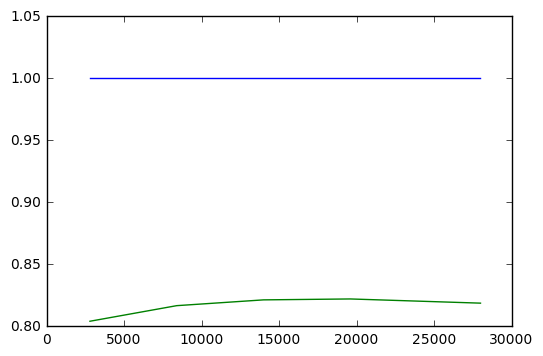

In [47]:
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(clf,combined,combinedLabels,train_sizes = np.array([0.1, 0.3,0.5,0.7,1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.plot(train_sizes,train_score_mean)
plt.plot(train_sizes, test_score_mean)
plt.show()

In [53]:
#using classifier to predict test images on public leader board
Rand = np.random.choice(RandInd,18000)
Rtrain = combined[RandInd,:]
Rlabels = combinedLabels[RandInd]
clf = SVC(kernel = 'rbf', C = 55, gamma = 0.0373157)
clf.fit(Rtrain,Rlabels)
pred = clf.predict(test)
dfPred = pd.read_csv('sample_submission.csv',header=0)
dfPred['Label']= pd.DataFrame(pred)
dfPred.to_csv('mySubmission.csv', index=False)
#84.143% LeaderBoard Accuracy